In [17]:
import ee
import geemap
import geopandas as gpd

In [18]:
# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-clowd')

In [19]:
shape_name="Area"
scale = 500
n_tree = 500

# min max loader
min_vh, max_vh = -33.10366675215105, -8.855827012834578
min_vv, max_vv = -23.899207331777774, -1.924832734821049
min_srtm, max_srtm = 0, 1160
min_slope, max_slope = 0, 1.3599382638931274

In [20]:
# Path to the shapefile in Google Drive
shapefile_path = f'shape-file/{shape_name}/{shape_name}.shp'

# Load the shapefile using GeoPandas
gdf = gpd.read_file(shapefile_path)

# Convert the GeoPandas DataFrame to a GeoJSON
gdf = gdf.to_crs("EPSG:4326")  # Make sure the CRS is WGS84
geojson = gdf.__geo_interface__

# Convert GeoJSON to an Earth Engine FeatureCollection
geometry = ee.FeatureCollection(geojson)

In [21]:
# Fetch GLDAS data
GLDAS = ee.ImageCollection("NASA/GLDAS/V022/CLSM/G025/DA1D") \
    .filterDate('2023-01-01', '2024-01-01') \
    .filterBounds(geometry) \
    .select('GWS_tavg') \
    .mean() \
    .clip(geometry)

# Visualization parameters
colorizedVis = {
    'min': 900,
    'max': 3000,
    'palette': [
        'FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901',
        '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01',
        '012E01', '011D01', '011301'
    ],
}

In [22]:
# Fetch Sentinel-1 data
sentinel1 = ee.ImageCollection("COPERNICUS/S1_GRD") \
    .filterDate('2023-01-01', '2024-01-01') \
    .filterBounds(geometry) \
    .mean() \
    .clip(geometry)

# Fetch SRTM data
SRTM = ee.Image("USGS/SRTMGL1_003").clip(geometry)

In [23]:
# Select bands
VH = sentinel1.select('VH')
VV = sentinel1.select('VV')
slope = ee.Terrain.slope(SRTM)

# Function to normalize data using Min-Max scaling
def normalize(image):
    bandNames = image.bandNames()
    minDict = image.reduceRegion(reducer=ee.Reducer.min(), geometry=geometry, scale=scale, maxPixels=1e8, bestEffort=True, tileScale=4)
    maxDict = image.reduceRegion(reducer=ee.Reducer.max(), geometry=geometry, scale=scale, maxPixels=1e8, bestEffort=True, tileScale=4)
    mins = ee.Image.constant(minDict.values(bandNames))
    maxs = ee.Image.constant(maxDict.values(bandNames))
    normalized = image.subtract(mins).divide(maxs.subtract(mins))
    return normalized

In [24]:
# Combine all parameters
param = VH.addBands(VV).addBands(SRTM).addBands(slope).addBands(GLDAS)
normalizedImage = normalize(param)

# Prepare training data
GLDAS_Int = GLDAS.multiply(1000).toInt()
coorsfeat = GLDAS_Int.reduceToVectors(reducer=None, geometry=geometry, scale=27830, geometryType='centroid', labelProperty='GWS', eightConnected=False)

# Extract training data
training = normalizedImage.sampleRegions(collection=coorsfeat, properties=['GWS'], scale=27830, geometries=True)

In [25]:
# Split data into training and testing sets
training = training.randomColumn()
train = training.filter(ee.Filter.lt('random', 0.6))
test = training.filter(ee.Filter.gte('random', 0.6))

# Train a Random Forest regressor with fewer trees
bands = ['VH', 'VV', 'elevation', 'slope']
classifier = ee.Classifier.smileRandomForest(
    numberOfTrees=n_tree,  
    variablesPerSplit=1,
    minLeafPopulation=1,
    bagFraction=0.5,
    maxNodes=4,
    seed=0
).setOutputMode('REGRESSION').train(
    features=train,
    classProperty='GWS',
    inputProperties=bands
)

# Predict using the trained model
regression = normalizedImage.select(bands).classify(classifier, 'predicted')
regression_Scaled = regression.divide(1000)

In [26]:
viz = {
    'min': regression_Scaled.reduceRegion(
        reducer=ee.Reducer.min(), 
        geometry=geometry, 
        scale=scale, 
        bestEffort=True, 
        maxPixels=1e8
    ).getInfo()['predicted'],  # Ensure 'predicted' is the correct key
    'max': regression_Scaled.reduceRegion(
        reducer=ee.Reducer.max(), 
        geometry=geometry, 
        scale=scale, 
        bestEffort=True, 
        maxPixels=1e8
    ).getInfo()['predicted'],  # Ensure 'predicted' is the correct key
    'palette': ['blue', 'green', 'red', 'orange']
}

In [27]:
# Calculate Residuals
uji_train = train.select(bands).classify(classifier, 'predicted')
uji_train_1 = GLDAS.sampleRegions(collection=uji_train, geometries=True)
observationTraining = ee.Array(uji_train_1.aggregate_array('GWS_tavg')).getInfo()
predictionTraining = ee.Array(uji_train_1.aggregate_array('predicted')).divide(1000).getInfo()
residualsTraining = [abs((obs - pred) / obs * 100) for obs, pred in zip(observationTraining, predictionTraining)]
MAPETraining = sum(residualsTraining) / len(residualsTraining)

uji_test = test.select(bands).classify(classifier, 'predicted')
uji_test_1 = GLDAS.sampleRegions(collection=uji_test, geometries=True)
observationTesting = ee.Array(uji_test_1.aggregate_array('GWS_tavg')).getInfo()
predictionTesting = ee.Array(uji_test_1.aggregate_array('predicted')).divide(1000).getInfo()
residualsTesting = [abs((obs - pred) / obs * 100) for obs, pred in zip(observationTesting, predictionTesting)]
MAPETesting = sum(residualsTesting) / len(residualsTesting)

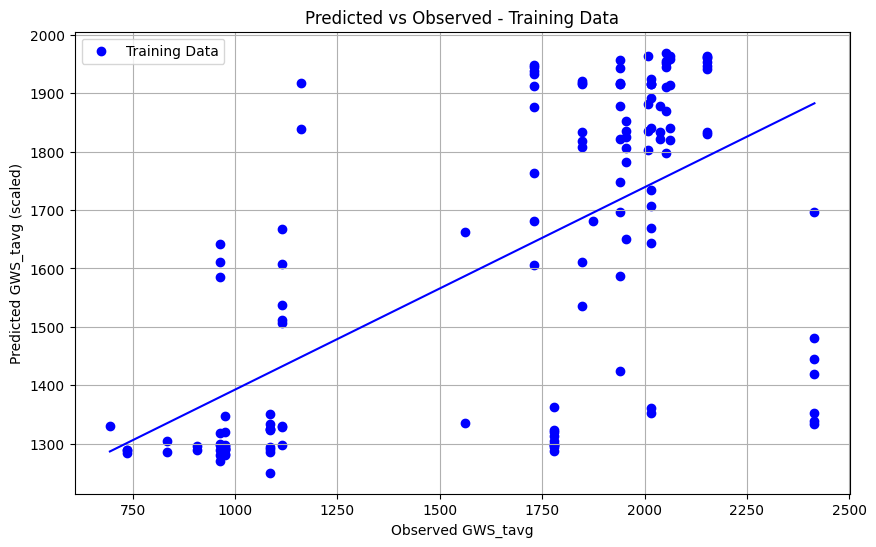

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting Predicted vs Observed - Training Data
plt.figure(figsize=(10, 6))
plt.scatter(observationTraining, predictionTraining, c='blue', label='Training Data')
plt.plot(np.unique(observationTraining), np.poly1d(np.polyfit(observationTraining, predictionTraining, 1))(np.unique(observationTraining)), color='blue')
plt.xlabel('Observed GWS_tavg')
plt.ylabel('Predicted GWS_tavg (scaled)')
plt.title('Predicted vs Observed - Training Data')
plt.legend()
plt.grid(True)
plt.show()

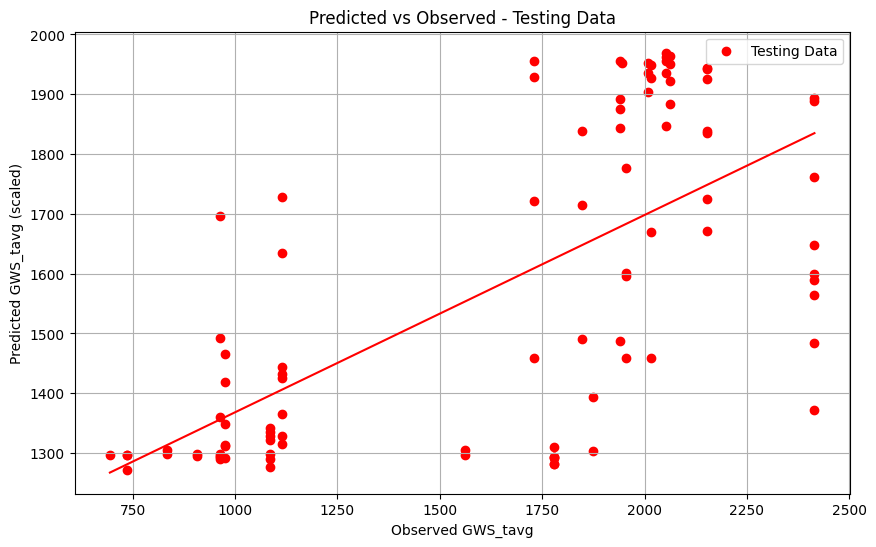

In [29]:
# Plotting Predicted vs Observed - Testing Data
plt.figure(figsize=(10, 6))
plt.scatter(observationTesting, predictionTesting, c='red', label='Testing Data')
plt.plot(np.unique(observationTesting), np.poly1d(np.polyfit(observationTesting, predictionTesting, 1))(np.unique(observationTesting)), color='red')
plt.xlabel('Observed GWS_tavg')
plt.ylabel('Predicted GWS_tavg (scaled)')
plt.title('Predicted vs Observed - Testing Data')
plt.legend()
plt.grid(True)
plt.show()

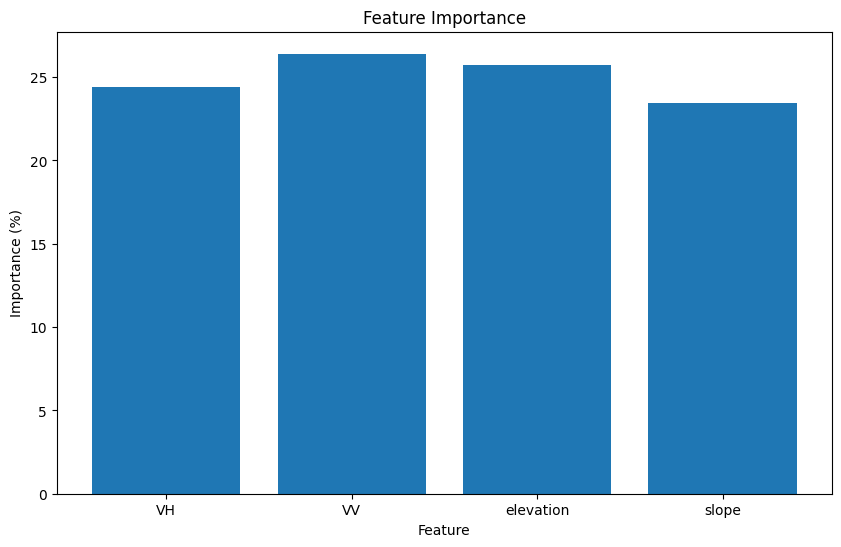

In [30]:
# Feature Importance
importance = ee.Dictionary(classifier.explain().get('importance')).getInfo()
sum_importance = sum(importance.values())
relativeImportance = {k: (v * 100) / sum_importance for k, v in importance.items()}

# Plotting Feature Importance
plt.figure(figsize=(10, 6))
plt.bar(relativeImportance.keys(), relativeImportance.values())
plt.xlabel('Feature')
plt.ylabel('Importance (%)')
plt.title('Feature Importance')
plt.show()

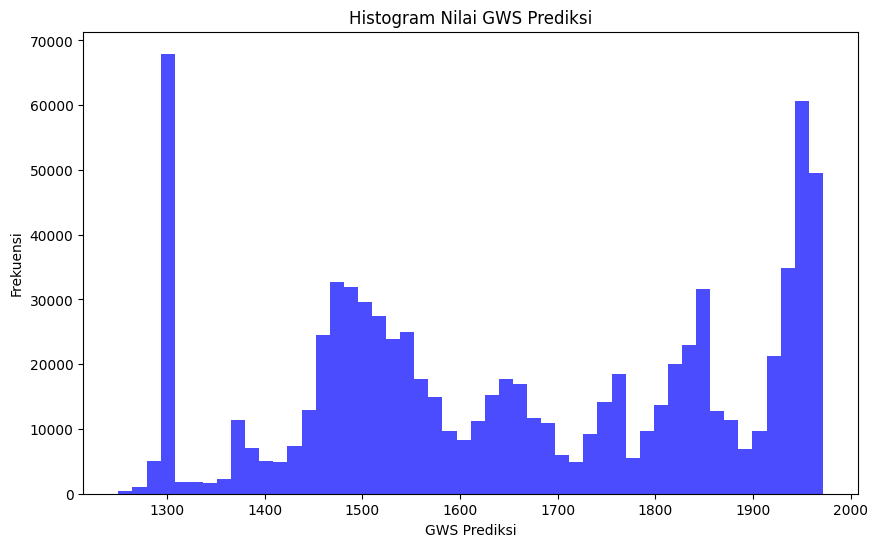

In [31]:
# Histogram of Predicted Values
predicted_values = regression_Scaled.reduceRegion(
    reducer=ee.Reducer.toList(),
    geometry=geometry,
    scale=scale,
    maxPixels=1e8
).get('predicted').getInfo()

plt.figure(figsize=(10, 6))
plt.hist(predicted_values, bins=50, color='blue', alpha=0.7)
plt.xlabel('GWS Prediksi')
plt.ylabel('Frekuensi')
plt.title('Histogram Nilai GWS Prediksi')
plt.show()

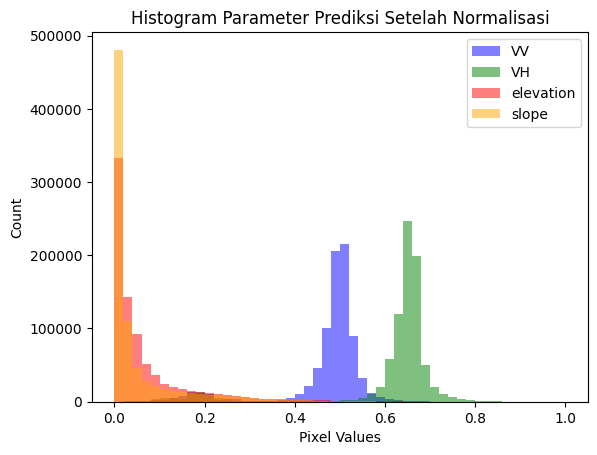

In [32]:
# Histogram of Normalized Parameters
params = ['VV', 'VH', 'elevation', 'slope']
colors = ['blue', 'green', 'red', 'orange']

for param, color in zip(params, colors):
    param_values = normalizedImage.select(param).reduceRegion(
        reducer=ee.Reducer.toList(),
        geometry=geometry,
        scale=scale,
        maxPixels=1e8
    ).get(param).getInfo()
    
    plt.hist(param_values, bins=50, color=color, alpha=0.5, label=param)

plt.xlabel('Pixel Values')
plt.ylabel('Count')
plt.title('Histogram Parameter Prediksi Setelah Normalisasi')
plt.legend()
plt.show()

In [33]:
# Create a map and add layers
Map = geemap.Map()
Map.addLayer(geometry, {}, 'Batas Kabupaten Ketapang')
Map.addLayer(GLDAS, colorizedVis, 'GWS')
Map.addLayer(VH, {'min': min_vh, 'max': max_vh, 'palette': viz['palette']}, 'VH')
Map.addLayer(VV, {'min': min_vv, 'max': max_vv, 'palette': viz['palette']}, 'VV')
Map.addLayer(SRTM, {'min': min_srtm, 'max': max_srtm, 'palette': viz['palette']}, 'SRTM')
Map.addLayer(slope, {'min': min_slope, 'max': max_slope, 'palette': viz['palette']}, 'Slope')
Map.addLayer(train, {'color': '0000FF'}, 'Train')
Map.addLayer(test, {'color': 'DC143C'}, 'Test')
Map.addLayer(coorsfeat, {'color': 'FF0000'}, 'Training Sample')
Map.addLayer(regression_Scaled, viz, 'Regression')

In [34]:
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [35]:
# Export map to HTML file
Map.to_html(filename='map.html')